<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/4Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
#df = df[df['n/m'] != 2]
print(df.shape[0])

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

8750


In [2]:
X_modified = X.drop([ 'median', 'range',  'max', 'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','m'], axis = 1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

     n    n/m   av.length    std.dev   k
0   22   2.75   81.045456  58.938614  22
1  110   2.75   49.545456  27.661995  70
2   40   2.00   93.574997  38.792603  34
3   60  10.00  144.649994  56.316547  50
4   72   9.00   97.597221  21.133154  47


In [3]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

1655304


In [4]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({1: 1416, 17: 1416, 341: 1416, 512: 1416, 2: 1416, 23: 1416, 67: 1416, 145: 1416, 19: 1416, 48: 1416, 115: 1416, 1404: 1416, 1130: 1416, 99999: 1416, 775: 1416, 141: 1416, 51: 1416, 0: 1416, 6: 1416, 5: 1416, 3: 1416, 4: 1416, 124: 1416, 73: 1416, 91: 1416, 2900: 1416, 738: 1416, 9: 1416, 47: 1416, 7: 1416, 85: 1416, 1981: 1416, 35: 1416, 871: 1416, 24: 1416, 11: 1416, 608: 1416, 219: 1416, 78: 1416, 36: 1416, 364: 1416, 10: 1416, 549: 1416, 1357: 1416, 244: 1416, 203: 1416, 1198: 1416, 31: 1416, 93: 1416, 8: 1416, 83: 1416, 1078: 1416, 114: 1416, 99: 1416, 252: 1416, 316: 1416, 84: 1416, 12: 1416, 486: 1416, 61: 1416, 55: 1416, 43: 1416, 45: 1416, 50: 1416, 186: 1416, 41: 1416, 249: 1416, 174: 1416, 53: 1416, 37: 1416, 33: 1416, 319: 1416, 18: 1416, 30: 1416, 15: 1416, 74: 1416, 157: 1416, 117: 1416, 4058: 1416, 107: 1416, 1310: 1416, 311: 1416, 56: 1416, 357: 1416, 76: 1416, 57: 1416, 242: 1416, 635: 1416, 1135: 1416, 21: 1416, 1037: 1416, 65: 1416, 46: 1416, 1245: 1416, 22: 

In [5]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow
from tensorflow import keras 


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,1))
    return 99999*1/(1+K.exp(-x))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.2))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    #model.add(Dense(32, activation='relu'))

    #model.add(Dense(64, activation='relu'))

    model.add(Dense(4, activation='relu'))
    
    model.add(Dense(1, activation = custom_activation))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')

    return model

In [6]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=30, batch_size=256, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/30
5367/5367 [==============================] - 28s 5ms/step - loss: 36678016.0000
Epoch 2/30
5367/5367 [==============================] - 12s 2ms/step - loss: 6199723.5000
Epoch 3/30
5367/5367 [==============================] - 13s 2ms/step - loss: 5611516.0000
Epoch 4/30
5367/5367 [==============================] - 13s 2ms/step - loss: 5631629.0000
Epoch 5/30
5367/5367 [==============================] - 12s 2ms/step - loss: 5534076.0000
Epoch 6/30
5367/5367 [==============================] - 12s 2ms/step - loss: 5454118.0000
Epoch 7/30
5367/5367 [==============================] - 12s 2ms/step - loss: 5327925.5000
Epoch 8/30
5367/5367 [==============================] - 12s 2ms/step - loss: 5462130.5000
Epoch 9/30
5367/5367 [==============================] - 13s 2ms/step - loss: 5499212.0000
Epoch 10/30
5367/5367 [==============================] - 14s 3ms/step - loss: 5385193.0000
Epoch 11/30
5367/5367 [==============================] - 12s 2ms/step - loss: 5491826.0000
Epoch 1

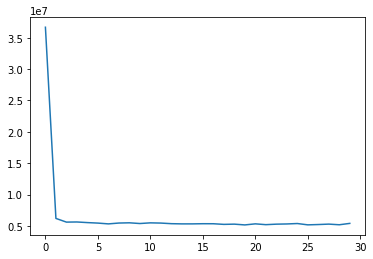

In [7]:
plt.plot(history.history['loss'])

In [8]:
#from sklearn.metrics import r2_score
#prediction = estimator.predict(X_val)
#print("r_square score: ", r2_score(y_val,prediction))
##y_test = sc2.inverse_transform(y_test.reshape(-1,1))
#yy = np.array(y_val)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
#predd = np.array(prediction)
#for i in range(len(yy)):
#  if(yy[i]-predd[i] > 99000):
#    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

In [9]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#print("RMSE:")
#sqrt(mean_squared_error(yy, predd)) 

In [10]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
for i in range(len(yy)):
  if(yy[i]-predd[i] > 99000):
    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

1100/1100 [==============================] - 2s 1ms/step
r_square score:  0.5410915745980163
real value of y_test: 99999 -> the predict: 0.3066123


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

RMSE:


2097.2493201011453